# Uncluttering Your Inbox


# 00. Introduction

## 00.01. Overall Idea

- The idea is that given a new email, predict whether the user will consider it clutter or non-clutter.
- Inspired by the "Uncluttering Your Inbox" example in the [MBML Book](https://mbmlbook.com/EmailClassifier.html) which proposes a model that predicts whether the user will reply to an email or not based on a set of features not related to the actual body of the email.
- We consider emails that are moved into the deleted folder as clutter, and those kept into the inbox folder as non-clutter. 
- We develop a number of classification models to compare various feature set choices as well as personalized and non-personalized classifiers.

### Research Questions

- How to extend the model suggested in the book to one that also uses topic modeling on the email body?
- How to extend the model suggested in the book to a hierarchal one to better model personalized choices?
- How do all the models compare?

## 00.02. Dataset

- We used Enron Email Dataset (http://www.cs.cmu.edu/~enron/), which contains a total of about 0.5M messages and which is, as they mention, "_the only substantial collection of "real" email that is public_".
- Separate scripts were developed and used to prepare and preprocess the dataset from the raw files, those same scripts are used here to load the processed data.
- On a high level the preprocessing of the raw dataset included modeling and preprocessing email bodies.

### Modeling

#### Person
- sname: short unique name
- name: full name
- email1: primary email
- email2: secondary email

#### Email
- to: list of email addresses in the "to" field
- from: sender's email address
- date: the date of the email
- cc: list of email addresses in the "cc" field
- bcc: list of email addresses in the "bcc" field
- subject: the subject of the email
- body: the text body of the email

### Text Preprocessing

- Remove punctuation
- Lemmatization
- Make lowercase
- Remove stopwords
- Remove numbers and words with digits
- Remove words of only 1 or 2 characters
- Remove some words (http, www, com)

## 00.03. How to Run this notebook?

1. You need the _processed-mail_ folder which contains the processed dataset (needs to be unzipped).
2. You need the two files _DataPrepTools.py_ and _Dateset.py_ to load the processed dataset.
3. You need to include the path to the directory containing these two code files in section 01.02.
4. You need to include the path to the _processed-mail_ folder by setting the value of the variable _processed_dataset_path_ in section 02.01.
5. If you got errors while installing packages in section 01.01 because of conflicting package versions (mostly when running in colab) then you need to restart the notebook runtime and run the cell again.
6. The section 3.2. doesn't need to be run for the reasons described in the begining of that section.

N.B. The notebook is developed and tested in Google Colab.

# 01. Setup

## 01.01. Install Packages & Prerequisites

In [ ]:
# Install packages & prerequisites
!pip install pyro-ppl
!pip install pyldavis
!pip install seaborn
!pip install nltk
!pip install spacy
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


## 01.02. Load Preprocessing Files

In [ ]:
import sys

# option 1: load from drive
from google.colab import drive
drive.mount('/content/drive')
sys.path.insert(0, '/content/drive/MyDrive/Colab Data/MBML/code')

# option 2: load from content if uploaded to this session (colab)
# sys.path.insert(0, '/content')

# option 3: load from local file system
# sys.path.insert(0, '/path/to/code')

from Dataset import Dataset
from DataPrepTools import *

Mounted at /content/drive
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 01.03. Import Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import seaborn as sns

import torch
from torch import nn
from torch.distributions import constraints
import functools

import pyro
import pyro.distributions as dist
from pyro.optim import Adam, ClippedAdam
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO, JitTraceEnum_ELBO, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList, AutoDelta

import gensim
import pyLDAvis
import pyLDAvis.gensim_models as pyldagensim

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# to collect the accuracies of all  the models
accuracies = []

# 02. Prepare Initial Datatset

## 02.01. Load Preprocessed Data

Preprocessing the Enron dataset to model individuals, their emails and preprocess the body of each email is a time consuming process. So this process has already been done and the results are saved as object files which need to be loaded here.

In [ ]:
# option 1: load from drive
processed_dataset_path = '/content/drive/MyDrive/Colab Data/MBML/processed-mail'

# option 2: load from content if uploaded to this session (colab)
# processed_dataset_path = '/content/processed-mail'

# option 3: load from local file system
# processed_dataset_path = '/path/to/processed-mail'

# the dataset is comprised of emails belonging to many individuals
# here we can choose which individuals to load their emails
individuals = ['allen-p', 'arnold-j', 'arora-h', 'watson-k',
               'badeer-r', 'bailey-s', 'bass-e', 'dean-c',
               'baughman-d', 'beck-s', 'benson-r', 'davis-d',
               'meyers-a', 'carson-m', 'jones-t', 'hernandez-j',
               'shapiro-r', 'shively-h', 'slinger-r', 'solberg-g',
               'thomas-p', 'ward-k', 'zipper-a', 'parks-j',
               'sanders-r', 'staab-t', 'tholt-j', 'whitt-m',
               'scott-s', 'white-s', 'wolfe-j', 'smith-m']

ds = Dataset.load_processed_dataset(processed_dataset_path, individuals)
ds.load_dictionary(processed_dataset_path)

print('Dictionary Size:', ds.get_dict_size())
print('Total mails count: ', ds.get_mails_count())
print('Individuals count: ', ds.get_individuals_count())
print('------------------------------------------------')
for i in ds.get_all():
    print('{0}, inbox: {1}, deleted: {2} '.format(i.name, i.get_inbox_mail_count(), i.get_deleted_mail_count()))

loading dictionary...
done loading dictionary!
Dictionary Size: 42859
Total mails count:  9983
Individuals count:  32
------------------------------------------------
Susan M Scott, inbox: 200, deleted: 200 
Ward, Kim S., inbox: 200, deleted: 200 
Jones, Tana, inbox: 200, deleted: 66 
Bailey, Susan, inbox: 4, deleted: 200 
Thomas, Paul D., inbox: 200, deleted: 200 
Wolfe, Jason, inbox: 200, deleted: 108 
Arora, Harry, inbox: 79, deleted: 197 
Benson, Robert, inbox: 200, deleted: 200 
Smith, Matt, inbox: 200, deleted: 85 
Allen, Phillip K., inbox: 66, deleted: 200 
Slinger, Ryan, inbox: 49, deleted: 35 
Hernandez, Juan, inbox: 200, deleted: 40 
Shively, Hunter S., inbox: 143, deleted: 200 
Sally Beck, inbox: 200, deleted: 200 
Watson, Kimberly, inbox: 200, deleted: 200 
Solberg, Geir, inbox: 167, deleted: 200 
Parks, Joe, inbox: 200, deleted: 200 
Meyers, Albert, inbox: 22, deleted: 200 
Bass, Eric, inbox: 200, deleted: 200 
White, Stacey W., inbox: 200, deleted: 200 
Baughman Jr., Don,

## 02.02. Prepare Initial DataFrame

We put the dataset into an initial dataframe and we add the _ToCcPos_ features (using functions imported from the auxiliary scripts).

In [ ]:
# build pandas dataset
data = []

for i in ds.get_all():

  for m in i.get_deleted_mail():
    ToCcPos = ToCcPosition(i, m)
    row = []
    row.append(i.sname)
    row.append(i.name)
    row.append(i.email1)
    row.append(i.email2)
    row.append(m.subject)
    row.append(m.get_body_processed())
    row.append(m.get_body_bow())
    row.append(len(m.subject))
    row.append(len(m.get_body_str()))
    row.append(int(ToCcPos[0]))
    row.append(int(ToCcPos[1]))
    row.append(int(ToCcPos[2]))
    row.append(int(ToCcPos[3]))
    row.append(int(ToCcPos[4]))
    row.append(int(ToCcPos[5]))
    row.append(1) # deleted
    data.append(row)
    
  for m in i.get_inbox_mail():
    ToCcPos = ToCcPosition(i, m)
    row = []
    row.append(i.sname)
    row.append(i.name)
    row.append(i.email1)
    row.append(i.email2)
    row.append(m.subject)
    row.append(m.get_body_processed())
    row.append(m.get_body_bow())
    row.append(len(m.subject))
    row.append(len(m.get_body_str()))
    row.append(int(ToCcPos[0]))
    row.append(int(ToCcPos[1]))
    row.append(int(ToCcPos[2]))
    row.append(int(ToCcPos[3]))
    row.append(int(ToCcPos[4]))
    row.append(int(ToCcPos[5]))
    row.append(0) # inbox
    data.append(row)

# create pandas DataFrame
df = pd.DataFrame(data, columns = ['sname', 'name', 'email1', 'email2', 
                                   'subject', 'processedBody', 'bowBody','subjectLength', 'bodyLength',
                                   'notOnToOrCcLine', 'firstOnToLine', 'secondOnToLine', 'thirdOrLaterOnToLine',
                                   'firstOnCcLine', 'secondOrLaterOnCcLine', 'deleted'
                                   ])

In [ ]:
df.head()

,sname,name,email1,email2,subject,processedBody,bowBody,subjectLength,bodyLength,notOnToOrCcLine,firstOnToLine,secondOnToLine,thirdOrLaterOnToLine,firstOnCcLine,secondOrLaterOnCcLine,deleted
0,scott-s,Susan M Scott,susan.scott@enron.com,susan.scott@enron.com,A.Word.A.Day--inkhorn term,"[word, speech, appearance, book, useful, turm,...","[(0, 1), (15, 1), (43, 1), (50, 1), (56, 1), (...",26,1234,1,0,0,0,0,0,1
1,scott-s,Susan M Scott,susan.scott@enron.com,susan.scott@enron.com,A.Word.A.Day--euphemism,"[budget, employer, send, thing, service, help,...","[(10, 1), (25, 1), (43, 1), (48, 1), (49, 1), ...",23,1840,1,0,0,0,0,0,1
2,scott-s,Susan M Scott,susan.scott@enron.com,susan.scott@enron.com,A.Word.A.Day--sticky wicket,"[checkout, want, need, ground, coalition, play...","[(0, 1), (7, 1), (10, 1), (15, 1), (43, 1), (4...",27,2307,1,0,0,0,0,0,1
3,scott-s,Susan M Scott,susan.scott@enron.com,susan.scott@enron.com,A.Word.A.Day--dipsy doodle,"[word, rather, kind, never, awad, know, useful...","[(10, 1), (43, 1), (48, 1), (50, 1), (56, 1), ...",26,1399,1,0,0,0,0,0,1
4,scott-s,Susan M Scott,susan.scott@enron.com,susan.scott@enron.com,A.Word.A.Day--hat trick,"[today, treat, friend, goal, give, player, emp...","[(43, 1), (48, 1), (50, 1), (56, 1), (67, 1), ...",23,1799,1,0,0,0,0,0,1


## 02.03. Adding Features

We divide the body length and the subject length into bins and we add the resulting features to the dataframe.

In [ ]:
# we divide body lengths for emails into bins

# group 1
one = df.loc[(df['bodyLength'] >= 0) & (df['bodyLength'] <= 100)]
d_one = one.loc[df['deleted'] == 1]
df['bodyLength[0-100]'] = (df['bodyLength'] >= 0) & (df['bodyLength'] <= 100)
df['bodyLength[0-100]'] = df['bodyLength[0-100]'].astype(int)

# group 2
two = df.loc[(df['bodyLength'] >= 101) & (df['bodyLength'] <= 200)]
d_two = two.loc[df['deleted'] == 1]
df['bodyLength[101-200]'] = (df['bodyLength'] >= 101) & (df['bodyLength'] <= 200)
df['bodyLength[101-200]'] = df['bodyLength[101-200]'].astype(int)

# group 3
three = df.loc[(df['bodyLength'] >= 201) & (df['bodyLength'] <= 400)]
d_three = three.loc[df['deleted'] == 1]
df['bodyLength[201-400]'] = (df['bodyLength'] >= 201) & (df['bodyLength'] <= 400)
df['bodyLength[201-400]'] = df['bodyLength[201-400]'].astype(int)

# group 4
four = df.loc[(df['bodyLength'] >= 401) & (df['bodyLength'] <= 1000)]
d_four = four.loc[df['deleted'] == 1]
df['bodyLength[401-1000]'] = (df['bodyLength'] >= 401) & (df['bodyLength'] <= 1000)
df['bodyLength[401-1000]'] = df['bodyLength[401-1000]'].astype(int)

# group 5
five = df.loc[(df['bodyLength'] >= 1001) & (df['bodyLength'] <= 2000)]
d_five = five.loc[df['deleted'] == 1]
df['bodyLength[1001-2000]'] = (df['bodyLength'] >= 1001) & (df['bodyLength'] <= 2000)
df['bodyLength[1001-2000]'] = df['bodyLength[1001-2000]'].astype(int)

# group 6
six = df.loc[(df['bodyLength'] >= 2001) & (df['bodyLength'] <= 5000)]
d_six = six.loc[df['deleted'] == 1]
df['bodyLength[2001-5000]'] = (df['bodyLength'] >= 2001) & (df['bodyLength'] <= 5000)
df['bodyLength[2001-5000]'] = df['bodyLength[2001-5000]'].astype(int)

# group 7
seven = df.loc[(df['bodyLength'] >= 5001)]
d_seven = seven.loc[df['deleted'] == 1]
df['bodyLength[>5000]'] = (df['bodyLength'] >= 5001)
df['bodyLength[>5000]'] = df['bodyLength[>5000]'].astype(int)

In [ ]:
assert sum([len(one), len(two), len(three), len(four), len(five), len(six), len(seven)]) == len(df)

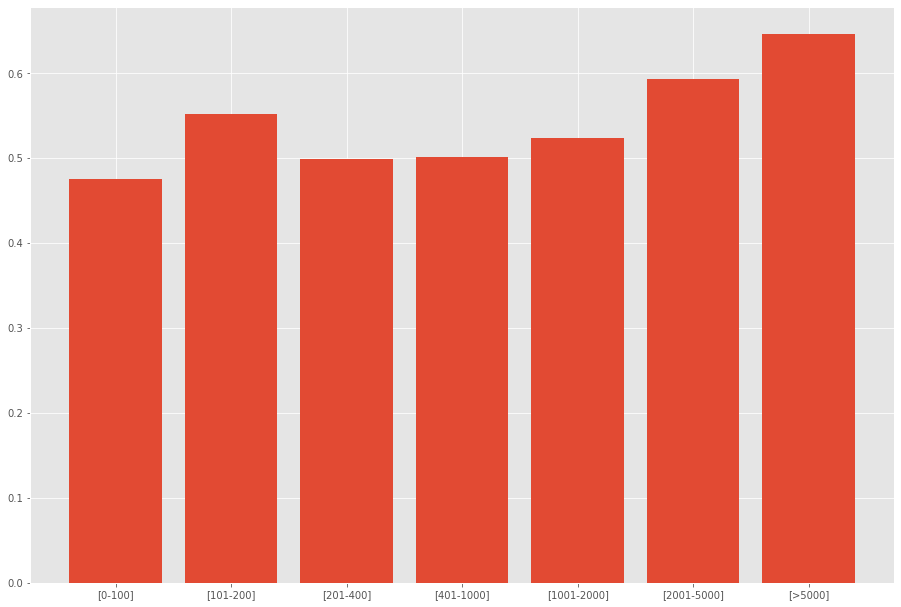

In [ ]:
# plotting the fraction of deleted emails for various body lengths
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lengths = ['[0-100]', '[101-200]', '[201-400]', '[401-1000]', '[1001-2000]', '[2001-5000]', '[>5000]']
deleted_fractions = [len(d_one)/len(one), len(d_two)/len(two), len(d_three)/len(three), 
            len(d_four)/len(four), len(d_five)/len(five), len(d_six)/len(six), 
            len(d_seven)/len(seven)]
ax.bar(lengths, deleted_fractions)
plt.show()

In [ ]:
# we divide subject lengths for emails into bins

# group 1
one = df.loc[(df['subjectLength'] >= 0) & (df['subjectLength'] <= 7)]
d_one = one.loc[df['deleted'] == 1]
df['subjectLength[0-7]'] = (df['subjectLength'] >= 0) & (df['subjectLength'] <= 7)
df['subjectLength[0-7]'] = df['subjectLength[0-7]'].astype(int)

# group 2
two = df.loc[(df['subjectLength'] >= 8) & (df['subjectLength'] <= 13)]
d_two = two.loc[df['deleted'] == 1]
df['subjectLength[8-13]'] = (df['subjectLength'] >= 8) & (df['subjectLength'] <= 13)
df['subjectLength[8-13]'] = df['subjectLength[8-13]'].astype(int)

# group 3
three = df.loc[(df['subjectLength'] >= 14) & (df['subjectLength'] <= 20)]
d_three = three.loc[df['deleted'] == 1]
df['subjectLength[14-20]'] = (df['subjectLength'] >= 14) & (df['subjectLength'] <= 20)
df['subjectLength[14-20]'] = df['subjectLength[14-20]'].astype(int)

# group 4
four = df.loc[(df['subjectLength'] >= 21) & (df['subjectLength'] <= 30)]
d_four = four.loc[df['deleted'] == 1]
df['subjectLength[21-30]'] = (df['subjectLength'] >= 21) & (df['subjectLength'] <= 30)
df['subjectLength[21-30]'] = df['subjectLength[21-30]'].astype(int)

# group 5
five = df.loc[(df['subjectLength'] >= 31) & (df['subjectLength'] <= 45)]
d_five = five.loc[df['deleted'] == 1]
df['subjectLength[31-45]'] = (df['subjectLength'] >= 31) & (df['subjectLength'] <= 45)
df['subjectLength[31-45]'] = df['subjectLength[31-45]'].astype(int)

# group 6
six = df.loc[(df['subjectLength'] >= 46)]
d_six = six.loc[df['deleted'] == 1]
df['subjectLength[>45]'] = (df['subjectLength'] >= 46)
df['subjectLength[>45]'] = df['subjectLength[>45]'].astype(int)

In [ ]:
assert sum([len(one), len(two), len(three), len(four), len(five), len(six)]) == len(df)

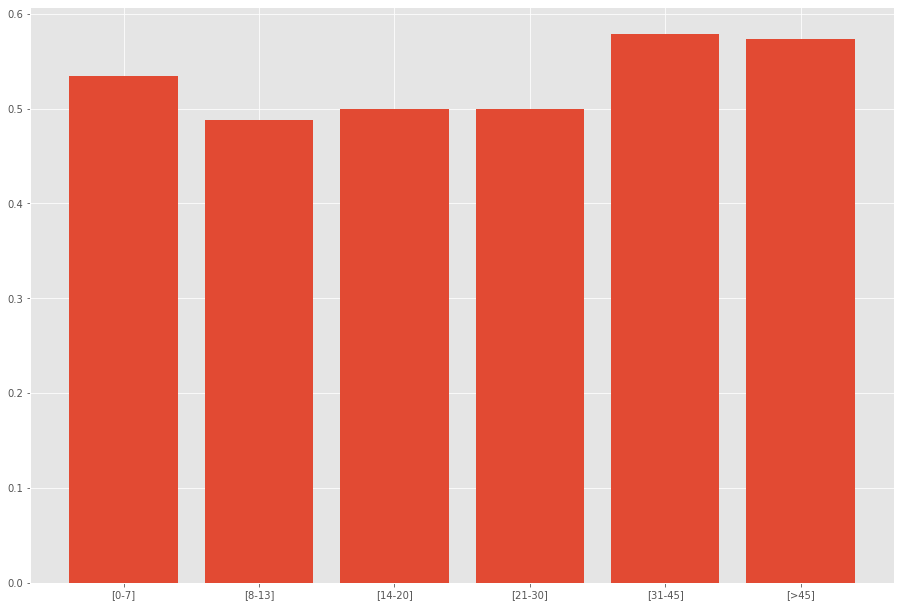

In [ ]:
# plotting the fraction of deleted emails for various subject lengths.
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lengths = ['[0-7]', '[8-13]', '[14-20]', '[21-30]', '[31-45]', '[>45]']
deleted_fractions = [len(d_one)/len(one), len(d_two)/len(two), 
                     len(d_three)/len(three), len(d_four)/len(four), 
                     len(d_five)/len(five), len(d_six)/len(six)]
ax.bar(lengths, deleted_fractions)
plt.show()

## 02.04. Exploring the dataset

In [ ]:
# moving lable to the end
df = df[[c for c in df if c not in ['deleted']] + ['deleted']]

In [ ]:
df.head()

,sname,name,email1,email2,subject,processedBody,bowBody,subjectLength,bodyLength,notOnToOrCcLine,firstOnToLine,secondOnToLine,thirdOrLaterOnToLine,firstOnCcLine,secondOrLaterOnCcLine,bodyLength[0-100],bodyLength[101-200],bodyLength[201-400],bodyLength[401-1000],bodyLength[1001-2000],bodyLength[2001-5000],bodyLength[>5000],subjectLength[0-7],subjectLength[8-13],subjectLength[14-20],subjectLength[21-30],subjectLength[31-45],subjectLength[>45],deleted
0,scott-s,Susan M Scott,susan.scott@enron.com,susan.scott@enron.com,A.Word.A.Day--inkhorn term,"[word, speech, appearance, book, useful, turm,...","[(0, 1), (15, 1), (43, 1), (50, 1), (56, 1), (...",26,1234,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
1,scott-s,Susan M Scott,susan.scott@enron.com,susan.scott@enron.com,A.Word.A.Day--euphemism,"[budget, employer, send, thing, service, help,...","[(10, 1), (25, 1), (43, 1), (48, 1), (49, 1), ...",23,1840,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
2,scott-s,Susan M Scott,susan.scott@enron.com,susan.scott@enron.com,A.Word.A.Day--sticky wicket,"[checkout, want, need, ground, coalition, play...","[(0, 1), (7, 1), (10, 1), (15, 1), (43, 1), (4...",27,2307,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
3,scott-s,Susan M Scott,susan.scott@enron.com,susan.scott@enron.com,A.Word.A.Day--dipsy doodle,"[word, rather, kind, never, awad, know, useful...","[(10, 1), (43, 1), (48, 1), (50, 1), (56, 1), ...",26,1399,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
4,scott-s,Susan M Scott,susan.scott@enron.com,susan.scott@enron.com,A.Word.A.Day--hat trick,"[today, treat, friend, goal, give, player, emp...","[(43, 1), (48, 1), (50, 1), (56, 1), (67, 1), ...",23,1799,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1


Dataset size: 9983
Dataset shape: (9983, 29)


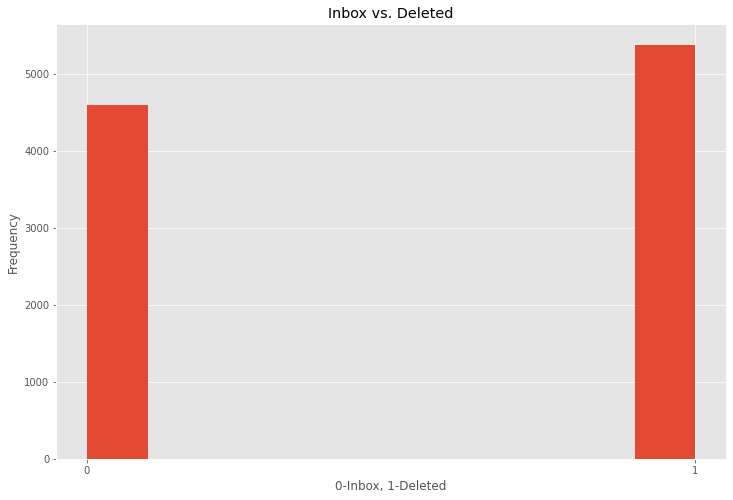

In [ ]:
print("Dataset size:", len(df))
print("Dataset shape:", df.shape)
df['deleted'].hist();
plt.title('Inbox vs. Deleted')
plt.xlabel('0-Inbox, 1-Deleted')
plt.ylabel('Frequency')
plt.xticks([0,1]);

# 03. Topic Modeling

## 03.01. Preparing dataset for topic modeling

The _bag of words (bow)_ for every email, along with the dictionary of the entire dataset were already generated in the preprocessing phase, here we need  to put them together in a form suitable for training the topic modeling models.

In [ ]:
dictionary = ds.get_dict()
mails_bows = []
mails_words = []

for i in ds.get_all():
  # add deleted emails of all individuals
  for m in i.get_deleted_mail():
    mails_words.append(m.get_body_processed())
    mails_bows.append(m.get_body_bow())
  # add inbox emails of all individuals
  for m in i.get_inbox_mail():
    mails_words.append(m.get_body_processed())
    mails_bows.append(m.get_body_bow())

# remove very short emails
mails_bows = [x for x in mails_bows if len(x) >= 3]
mails_words = [x for x in mails_words if len(x) >= 3]
assert len(mails_words) == len(mails_bows)

In [ ]:
print('Min email length:', min(len(x) for x in mails_bows))
print('Max email length:', max(len(x) for x in mails_bows))
print('Avg email length:', sum(len(x) for x in mails_bows) / len(mails_bows))

Min email length: 3
Max email length: 5665
Avg email length: 67.68581150752732


## 03.02. Topic Modeling with Pyro

An LDA model is used to perform topic modeling with Pyro. But despite many attempts this model is timing out during training. Even when a very small fraction of documents and a small number of words in each document are used, the model is taking very long time to train, and since the number of documents in training is very small the predications won't be that useful later for classification. This could be due to the large vocabulary size of (42859) but we're not sure. The model is kept here for completeness.

In [ ]:
# we need only word ids
mails_ids = []
for bow in mails_bows:
  mails_ids.append([i[0] for i in bow])
len(mails_ids)

9698

In [ ]:
# number of words = dictionary size
C = ds.get_dict_size()

# num of topics
K = 15

# num of documents
I = len(mails_bows)

# num of words per document
M = 20

C, K, I, M

(42859, 15, 9698, 20)

In [ ]:
W = np.zeros((I, M), dtype=int )
# W = np.full( (I, M), -1, dtype=int ) # var doc length
print(W.shape)
for i in range(I):
  for j in range(M):
    if j < len(mails_ids[i]):
      W[i,j] = mails_ids[i][j]

(9698, 20)


In [ ]:
# data is a [num_words_per_doc, num_documents] shaped array of word ids

num_words = C
num_topics = K
num_docs = I
num_words_per_doc = M

def model(data=None, batch_size=None):
    """ Make a plate of size num_topics with name "topics" and define a variable "topic_words".
          This represents the phi above. Use the equivalent of a uniform distribution for it  """
    with pyro.plate("topics", num_topics):
        topic_words = pyro.sample("topic_words", dist.Dirichlet(torch.ones(num_words) / num_words))

    """ Make two (nested) plates in here. One over documents and one over words
          Documents, called "documents":
          The plate over the documents should hold a variable "doc_topics" representing the theta above.
            Use the equivalent of a uniform distribution for it.
          
          Words, called "words":
          The plate over words, should have a topic assignment for each word (z_{i,j} above) which 
            should be enumerated.
          The second variable should be the words themselves which should be drawn from the "topic_words"
            using the assigned z_{i,j} and the observed data.

     """
    with pyro.plate("documents", num_docs) as ind:
        if data is not None:
            with pyro.util.ignore_jit_warnings():
                assert data.shape == (num_words_per_doc, num_docs)
            data = data[:, ind]
        doc_topics = pyro.sample("doc_topics", dist.Dirichlet(torch.ones(num_topics)/ num_topics))
        with pyro.plate("words", num_words_per_doc):
            word_topics = pyro.sample("word_topics", dist.Categorical(doc_topics), infer={"enumerate": "parallel"})
            data = pyro.sample("doc_words", dist.Categorical(topic_words[word_topics]), obs=data)

    return topic_words, data

In [ ]:
# We can generate synthetic data directly by calling the model.
true_topic_words, fake_data = model()
fake_data

In [ ]:
# because data is a [num_words_per_doc, num_documents] so we need to flip it
W_torch = torch.tensor(W.T).long()
W_torch.shape

In [ ]:
W_torch

In [ ]:
pyro.clear_param_store()

def my_local_guide(data=None, batch_size=None):
    topic_words_posterior = pyro.param(
            "topic_words_posterior",
            lambda: torch.ones(num_topics, num_words),
            constraint=constraints.positive)
    with pyro.plate("topics", num_topics):
        pyro.sample("topic_words", dist.Dirichlet(topic_words_posterior))
    
    doc_topics_posterior = pyro.param(
            "doc_topics_posterior",
            lambda: torch.ones(num_docs, num_topics),
            constraint=constraints.simplex)
    with pyro.plate("documents", num_docs, batch_size) as ind:
        pyro.sample("doc_topics", dist.Delta(doc_topics_posterior[ind], event_dim=1))
    
guide = AutoGuideList(model)
guide.add(AutoDiagonalNormal(pyro.poutine.block(model, expose=['doc_topics'])))
guide.add(my_local_guide)  # automatically wrapped in an AutoCallable

guide = my_local_guide

elbo = TraceEnum_ELBO(max_plate_nesting=3)

optim = ClippedAdam({'lr': 0.005})
svi = SVI(model, guide, optim, elbo)

# Define the number of optimization steps
n_steps = 400 # should be 4000

# do gradient steps
for step in range(n_steps):
    elbo = svi.step(W_torch, batch_size=10)
    if step % 100 == 0:
        #print('.', end='')
        print("[%d] ELBO: %.1f" % (step, elbo))

In [ ]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("topic_words",))
samples = predictive(W_torch)
samples["topic_words"].shape

In [ ]:
# Compute the argmax of the mean of all samples of topic for each word
#   this is the most likely topic for each word in our dictionary
samples["topic_words"].mean(axis=0)[0].argmax(axis=0)

In [ ]:
# Now compute the same for the real values
np.argmax(phi, axis=0)

In [ ]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("doc_topics",))
predictive = Predictive(model, guide=guide, num_samples=800)
samples = predictive(W_torch)

In [ ]:
samples.keys()

In [ ]:
doc_topics_posterior = samples["doc_topics"].mean(axis=0)
doc_topics_posterior.shape

In [ ]:
# Compute the argmax of the mean of all samples of topic for each document
#   this is the most likely topic for each document in our data
torch.argmax(doc_topics_posterior, axis=2)[0]

## 03.03. Topic Modeling with Gensim

To overcome the issue with the Pyro model, we used Gensim to perform topic modeling.

In [ ]:
corpus = mails_bows

Removing insignificant words from the corpus. This will make sure that the topics are more distinct and separated apart from each other.

In [ ]:
tfidf = gensim.models.TfidfModel(corpus, id2word=dictionary)
low_value = 0.03
words = []
words_missing_in_tfidf = []

for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = []

    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]

    low_value_words = [id for id,
                        value in tfidf[bow] if value < low_value]

    drops = low_value_words + words_missing_in_tfidf

    for item in drops:
        words.append(dictionary[item])

    words_missing_in_tfidf = [
        id for id in bow_ids if id not in tfidf_ids]
    new_bow = [b for b in bow if b[0]
                not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, 
                                            num_topics=15, random_state=100, 
                                            update_every=1, chunksize=100, 
                                            passes=10, alpha="auto")

In [ ]:
pyLDAvis.enable_notebook()
vis = pyldagensim.prepare(lda_model, corpus, dictionary, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.396744  0.223712       1        1  27.048102
5      0.121495 -0.412761       2        1   9.837351
1     -0.103608 -0.414621       3        1   9.647215
8     -0.109555  0.441484       4        1   9.312566
6      0.242091 -0.250692       5        1   6.884126
0      0.250770 -0.060903       6        1   5.347902
4      0.070921  0.231034       7        1   5.016498
7     -0.322325 -0.270842       8        1   4.857011
3     -0.412535  0.119607       9        1   4.579671
12     0.181323  0.360057      10        1   4.372622
9      0.450676 -0.034549      11        1   3.596451
2     -0.125292  0.056872      12        1   2.990677
13    -0.324957 -0.071832      13        1   2.438111
10    -0.245270  0.199788      14        1   2.296676
11    -0.070478 -0.116353      15        1   1.775018, topic_info=            Term         Freq        Total Category  logprob  loglift
120        thank  2627.000000  2627.000000  Default  30.0000  30.0000
99          send  2584.000000  2584.000000  Default  29.0000  29.0000
169        click  1139.000000  1139.000000  Default  28.0000  28.0000
456   attachment   876.000000   876.000000  Default  27.0000  27.0000
159      receive  1629.000000  1629.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
8893         sex    32.065330    32.996110  Topic15  -5.7773   4.0027
7396      bridge    32.016365    32.947135  Topic15  -5.7789   4.0027
3787       sweet    31.702640    32.633409  Topic15  -5.7887   4.0024
3733        sour    31.176763    32.107552  Topic15  -5.8054   4.0019
634          eat    61.067220   107.594952  Topic15  -5.1331   3.4650

[668 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
446      11  0.998643      acceptance
967       3  0.996844          accord
271       2  0.996688             act
1632      6  0.997079          active
1042     12  0.971478  administrative
...     ...       ...             ...
2345      8  0.995397         worried
8523     11  0.983451        yahoocom
958       8  0.995625            yard
1721      3  0.996422       yesterday
2541     14  0.985246           young

[927 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 6, 2, 9, 7, 1, 5, 8, 4, 13, 10, 3, 14, 11, 12])

## 03.04. Augmenting the dataset with topics

We augment the dataframe with features of the inferred topics of every email. We use the Gensim model as the Pyro model is timing out.

In [ ]:
# filter out rows with empty body
final_df = df[df['bowBody'].apply(lambda x: len(x)) > 0]

In [ ]:
# generate topics and merge with original ds
final_df = final_df.merge(final_df.apply(lambda x: lda_model.get_document_topics(x['bowBody'], minimum_probability=0.0), axis=1, result_type='expand'), 
    left_index=True, right_index=True)
final_df.shape

(9885, 44)

In [ ]:
# rename topic columns
column_indices = [29,30,31,32,33,34,35,36,37,38,39,40,41,42,43]
new_names = ['topic01','topic02','topic03','topic04','topic05','topic06','topic07',
             'topic08','topic09','topic10','topic11','topic12','topic13','topic14',
             'topic15']
old_names = final_df.columns[column_indices]
final_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

In [ ]:
# we need to keep only the second part of the gensim result
final_df['topic01'] = final_df['topic01'].apply(lambda x: x[1])
final_df['topic02'] = final_df['topic02'].apply(lambda x: x[1])
final_df['topic03'] = final_df['topic03'].apply(lambda x: x[1])
final_df['topic04'] = final_df['topic04'].apply(lambda x: x[1])
final_df['topic05'] = final_df['topic05'].apply(lambda x: x[1])
final_df['topic06'] = final_df['topic06'].apply(lambda x: x[1])
final_df['topic07'] = final_df['topic07'].apply(lambda x: x[1])
final_df['topic08'] = final_df['topic08'].apply(lambda x: x[1])
final_df['topic09'] = final_df['topic09'].apply(lambda x: x[1])
final_df['topic10'] = final_df['topic10'].apply(lambda x: x[1])
final_df['topic11'] = final_df['topic11'].apply(lambda x: x[1])
final_df['topic12'] = final_df['topic12'].apply(lambda x: x[1])
final_df['topic13'] = final_df['topic13'].apply(lambda x: x[1])
final_df['topic14'] = final_df['topic14'].apply(lambda x: x[1])
final_df['topic15'] = final_df['topic15'].apply(lambda x: x[1])

In [ ]:
# moving 'deleted' to the end again
final_df = final_df[[c for c in final_df if c not in ['deleted']] + ['deleted']]
print(final_df.shape)
final_df.head()

(9885, 44)


,sname,name,email1,email2,subject,processedBody,bowBody,subjectLength,bodyLength,notOnToOrCcLine,firstOnToLine,secondOnToLine,thirdOrLaterOnToLine,firstOnCcLine,secondOrLaterOnCcLine,bodyLength[0-100],bodyLength[101-200],bodyLength[201-400],bodyLength[401-1000],bodyLength[1001-2000],bodyLength[2001-5000],bodyLength[>5000],subjectLength[0-7],subjectLength[8-13],subjectLength[14-20],subjectLength[21-30],subjectLength[31-45],subjectLength[>45],topic01,topic02,topic03,topic04,topic05,topic06,topic07,topic08,topic09,topic10,topic11,topic12,topic13,topic14,topic15,deleted
0,scott-s,Susan M Scott,susan.scott@enron.com,susan.scott@enron.com,A.Word.A.Day--inkhorn term,"[word, speech, appearance, book, useful, turm,...","[(0, 1), (15, 1), (43, 1), (50, 1), (56, 1), (...",26,1234,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.109797,0.063648,0.002712,0.006687,0.050189,0.022361,0.049816,0.058614,0.052297,0.003479,0.092515,0.184843,0.043181,0.002230,0.257633,1
1,scott-s,Susan M Scott,susan.scott@enron.com,susan.scott@enron.com,A.Word.A.Day--euphemism,"[budget, employer, send, thing, service, help,...","[(10, 1), (25, 1), (43, 1), (48, 1), (49, 1), ...",23,1840,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.090545,0.233451,0.001414,0.034475,0.041726,0.040874,0.048653,0.133914,0.071313,0.001847,0.025867,0.048609,0.035519,0.001169,0.190625,1
2,scott-s,Susan M Scott,susan.scott@enron.com,susan.scott@enron.com,A.Word.A.Day--sticky wicket,"[checkout, want, need, ground, coalition, play...","[(0, 1), (7, 1), (10, 1), (15, 1), (43, 1), (4...",27,2307,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0.089859,0.065308,0.001284,0.098101,0.026808,0.164065,0.094549,0.071050,0.108191,0.021885,0.024344,0.001236,0.027172,0.001062,0.205085,1
3,scott-s,Susan M Scott,susan.scott@enron.com,susan.scott@enron.com,A.Word.A.Day--dipsy doodle,"[word, rather, kind, never, awad, know, useful...","[(10, 1), (43, 1), (48, 1), (50, 1), (56, 1), ...",26,1399,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.078704,0.099440,0.002228,0.033214,0.016874,0.111006,0.069661,0.102214,0.109213,0.017837,0.069548,0.002142,0.066220,0.001843,0.219855,1
4,scott-s,Susan M Scott,susan.scott@enron.com,susan.scott@enron.com,A.Word.A.Day--hat trick,"[today, treat, friend, goal, give, player, emp...","[(43, 1), (48, 1), (50, 1), (56, 1), (67, 1), ...",23,1799,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.018151,0.065144,0.001427,0.097256,0.052222,0.163299,0.140659,0.063030,0.141901,0.001836,0.051136,0.001371,0.027980,0.001180,0.173406,1


In [ ]:
# saving ds
final_df.to_csv(r'/content/drive/MyDrive/Colab Data/MBML/final_df.csv')

In [ ]:
# load ds
# final_df = pd.read_csv(r'/content/drive/MyDrive/Colab Data/MBML/final_df.csv') 

# 04. Simple Classification

In this section we build and compare several simple non-personalized classification models and we experiment with different feature sets.

## 04.01. Prepare Train/Test datasets

In [ ]:
print(final_df.shape)
final_df.head()

(9885, 44)


,sname,name,email1,email2,subject,processedBody,bowBody,subjectLength,bodyLength,notOnToOrCcLine,firstOnToLine,secondOnToLine,thirdOrLaterOnToLine,firstOnCcLine,secondOrLaterOnCcLine,bodyLength[0-100],bodyLength[101-200],bodyLength[201-400],bodyLength[401-1000],bodyLength[1001-2000],bodyLength[2001-5000],bodyLength[>5000],subjectLength[0-7],subjectLength[8-13],subjectLength[14-20],subjectLength[21-30],subjectLength[31-45],subjectLength[>45],topic01,topic02,topic03,topic04,topic05,topic06,topic07,topic08,topic09,topic10,topic11,topic12,topic13,topic14,topic15,deleted
0,scott-s,Susan M Scott,susan.scott@enron.com,susan.scott@enron.com,A.Word.A.Day--inkhorn term,"[word, speech, appearance, book, useful, turm,...","[(0, 1), (15, 1), (43, 1), (50, 1), (56, 1), (...",26,1234,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.109797,0.063648,0.002712,0.006687,0.050189,0.022361,0.049816,0.058614,0.052297,0.003479,0.092515,0.184843,0.043181,0.002230,0.257633,1
1,scott-s,Susan M Scott,susan.scott@enron.com,susan.scott@enron.com,A.Word.A.Day--euphemism,"[budget, employer, send, thing, service, help,...","[(10, 1), (25, 1), (43, 1), (48, 1), (49, 1), ...",23,1840,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.090545,0.233451,0.001414,0.034475,0.041726,0.040874,0.048653,0.133914,0.071313,0.001847,0.025867,0.048609,0.035519,0.001169,0.190625,1
2,scott-s,Susan M Scott,susan.scott@enron.com,susan.scott@enron.com,A.Word.A.Day--sticky wicket,"[checkout, want, need, ground, coalition, play...","[(0, 1), (7, 1), (10, 1), (15, 1), (43, 1), (4...",27,2307,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0.089859,0.065308,0.001284,0.098101,0.026808,0.164065,0.094549,0.071050,0.108191,0.021885,0.024344,0.001236,0.027172,0.001062,0.205085,1
3,scott-s,Susan M Scott,susan.scott@enron.com,susan.scott@enron.com,A.Word.A.Day--dipsy doodle,"[word, rather, kind, never, awad, know, useful...","[(10, 1), (43, 1), (48, 1), (50, 1), (56, 1), ...",26,1399,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.078704,0.099440,0.002228,0.033214,0.016874,0.111006,0.069661,0.102214,0.109213,0.017837,0.069548,0.002142,0.066220,0.001843,0.219855,1
4,scott-s,Susan M Scott,susan.scott@enron.com,susan.scott@enron.com,A.Word.A.Day--hat trick,"[today, treat, friend, goal, give, player, emp...","[(43, 1), (48, 1), (50, 1), (56, 1), (67, 1), ...",23,1799,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.018151,0.065144,0.001427,0.097256,0.052222,0.163299,0.140659,0.063030,0.141901,0.001836,0.051136,0.001371,0.027980,0.001180,0.173406,1


In [ ]:
# shuffle
final_df = final_df.sample(frac=1).reset_index(drop=True)

In [ ]:
print(final_df.shape)
final_df.head()

(9885, 44)


,sname,name,email1,email2,subject,processedBody,bowBody,subjectLength,bodyLength,notOnToOrCcLine,firstOnToLine,secondOnToLine,thirdOrLaterOnToLine,firstOnCcLine,secondOrLaterOnCcLine,bodyLength[0-100],bodyLength[101-200],bodyLength[201-400],bodyLength[401-1000],bodyLength[1001-2000],bodyLength[2001-5000],bodyLength[>5000],subjectLength[0-7],subjectLength[8-13],subjectLength[14-20],subjectLength[21-30],subjectLength[31-45],subjectLength[>45],topic01,topic02,topic03,topic04,topic05,topic06,topic07,topic08,topic09,topic10,topic11,topic12,topic13,topic14,topic15,deleted
0,beck-s,Sally Beck,sally.beck@enron.com,sally.beck@enron.com,\\spr1inf1\sapfiles\ifout\04000\20020102-DENWE...,"[payment, business, emailthi, isare, unit, tha...","[(11, 1), (120, 1), (225, 1), (260, 1), (424, ...",50,242,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.021829,0.091879,0.006890,0.016382,0.266443,0.072445,0.019697,0.016506,0.044190,0.009381,0.008569,0.006636,0.020877,0.005713,0.392563,0
1,bass-e,"Bass, Eric",eric.bass@enron.com,eric.bass@enron.com,Holiday Specials from Hawaiitropicals.com,"[today, novelty, reply, consist, price, gift, ...","[(0, 1), (32, 1), (43, 1), (48, 1), (54, 1), (...",41,1810,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0.247094,0.063344,0.002073,0.061400,0.039416,0.038206,0.111409,0.004965,0.016921,0.002685,0.016026,0.002004,0.005682,0.015165,0.373610,1
2,allen-p,"Allen, Phillip K.",k..allen@enron.com,phillip.allen@enron.com,Mortgage rates hit new lows,"[today, receipt, brokerdealer, reply, reserve,...","[(0, 1), (11, 1), (15, 1), (32, 1), (41, 1), (...",27,3055,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0.157582,0.070119,0.052106,0.078287,0.109527,0.084157,0.003841,0.026250,0.026601,0.034757,0.009434,0.009210,0.037483,0.017509,0.283137,1
3,ward-k,"Ward, Kim S.",s..ward@enron.com,kim.ward@enron.com,,[cell],"[(1972, 1)]",0,77,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0.047087,0.074944,0.014863,0.035337,0.052378,0.072908,0.042489,0.035604,0.095323,0.019089,0.018485,0.014314,0.040394,0.012323,0.424461,0
4,zipper-a,"Zipper, Andy",andy.zipper@enron.com,,GIDDINGS BBQ FLY IN DEC 15,"[noon, see, flyin, successful, like, bean, pil...","[(19, 1), (20, 1), (47, 1), (50, 1), (67, 1), ...",27,916,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0.008533,0.103858,0.002687,0.006684,0.051875,0.061260,0.037960,0.006464,0.099943,0.021313,0.044093,0.092402,0.052321,0.002228,0.408379,0


In [ ]:
# split train/test 
train_perc = 0.7 # percentage of training data
split_point = int(train_perc*len(final_df))

df_train = final_df.iloc[:split_point,:]
df_test = final_df.iloc[split_point+1:,:]

print("train df:", df_train.shape)
print("test df: ", df_test.shape)

train df: (6919, 44)
test df:  (2965, 44)


## 04.02. Classifier 101

In this starter model, we train a classifier using the following features:
- BodyLength (Numeric feature)
- SubjectLength (Numeric feature)
- ToCcPosiiton features (One-of-N-feature)

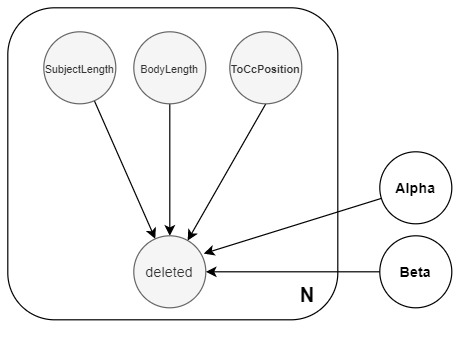

In [ ]:
df_train.head()

,sname,name,email1,email2,subject,processedBody,bowBody,subjectLength,bodyLength,notOnToOrCcLine,firstOnToLine,secondOnToLine,thirdOrLaterOnToLine,firstOnCcLine,secondOrLaterOnCcLine,bodyLength[0-100],bodyLength[101-200],bodyLength[201-400],bodyLength[401-1000],bodyLength[1001-2000],bodyLength[2001-5000],bodyLength[>5000],subjectLength[0-7],subjectLength[8-13],subjectLength[14-20],subjectLength[21-30],subjectLength[31-45],subjectLength[>45],topic01,topic02,topic03,topic04,topic05,topic06,topic07,topic08,topic09,topic10,topic11,topic12,topic13,topic14,topic15,deleted
0,beck-s,Sally Beck,sally.beck@enron.com,sally.beck@enron.com,\\spr1inf1\sapfiles\ifout\04000\20020102-DENWE...,"[payment, business, emailthi, isare, unit, tha...","[(11, 1), (120, 1), (225, 1), (260, 1), (424, ...",50,242,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.021829,0.091879,0.006890,0.016382,0.266443,0.072445,0.019697,0.016506,0.044190,0.009381,0.008569,0.006636,0.020877,0.005713,0.392563,0
1,bass-e,"Bass, Eric",eric.bass@enron.com,eric.bass@enron.com,Holiday Specials from Hawaiitropicals.com,"[today, novelty, reply, consist, price, gift, ...","[(0, 1), (32, 1), (43, 1), (48, 1), (54, 1), (...",41,1810,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0.247094,0.063344,0.002073,0.061400,0.039416,0.038206,0.111409,0.004965,0.016921,0.002685,0.016026,0.002004,0.005682,0.015165,0.373610,1
2,allen-p,"Allen, Phillip K.",k..allen@enron.com,phillip.allen@enron.com,Mortgage rates hit new lows,"[today, receipt, brokerdealer, reply, reserve,...","[(0, 1), (11, 1), (15, 1), (32, 1), (41, 1), (...",27,3055,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0.157582,0.070119,0.052106,0.078287,0.109527,0.084157,0.003841,0.026250,0.026601,0.034757,0.009434,0.009210,0.037483,0.017509,0.283137,1
3,ward-k,"Ward, Kim S.",s..ward@enron.com,kim.ward@enron.com,,[cell],"[(1972, 1)]",0,77,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0.047087,0.074944,0.014863,0.035337,0.052378,0.072908,0.042489,0.035604,0.095323,0.019089,0.018485,0.014314,0.040394,0.012323,0.424461,0
4,zipper-a,"Zipper, Andy",andy.zipper@enron.com,,GIDDINGS BBQ FLY IN DEC 15,"[noon, see, flyin, successful, like, bean, pil...","[(19, 1), (20, 1), (47, 1), (50, 1), (67, 1), ...",27,916,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0.008533,0.103858,0.002687,0.006684,0.051875,0.061260,0.037960,0.006464,0.099943,0.021313,0.044093,0.092402,0.052321,0.002228,0.408379,0


In [ ]:
# train
mat_train = df_train[["subjectLength", "bodyLength", "notOnToOrCcLine",	
                      "firstOnToLine",	"secondOnToLine",	"thirdOrLaterOnToLine",	
                      "firstOnCcLine",	"secondOrLaterOnCcLine",  "deleted"]].values
X_train = mat_train[:,0:-1]
y_train = mat_train[:,-1].astype("int")
print("train x: {}, y: {}".format(X_train.shape, y_train.shape))

# test
mat_test = df_test[["subjectLength", "bodyLength", "notOnToOrCcLine",	
                      "firstOnToLine",	"secondOnToLine",	"thirdOrLaterOnToLine",	
                      "firstOnCcLine",	"secondOrLaterOnCcLine",  "deleted"]].values
X_test = mat_test[:,0:-1]
y_test = mat_test[:,-1].astype("int")
print("test x: {}, y: {}".format(X_test.shape, y_test.shape))

train x: (6919, 8), y: (6919,)
test x: (2965, 8), y: (2965,)


In [ ]:
X_train[0]

array([ 50, 242,   0,   0,   1,   0,   0,   0])

In [ ]:
# create and fit a baseline model
logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', C=1)
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [1 1 1 ... 1 1 1]
true values: [1 0 1 ... 0 1 1]
Accuracy: 0.5284991568296796


In [ ]:
def model(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0, 5.).to_event()) # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            5.*torch.ones(X.shape[1])).to_event()) # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        logits = alpha + X.matmul(beta)
        y = pyro.sample("y", dist.Bernoulli(logits=logits), obs=obs)
        
    return y

In [ ]:
# Prepare data for Pyro
X_train = X_train.astype(np.float64)
y_train = y_train.astype(np.int32)

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()

In [ ]:
X_train[0]

tensor([ 50., 242.,   0.,   0.,   1.,   0.,   0.,   0.])

In [ ]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 30000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 16202757.9
[1000] ELBO: 4256092.3
[2000] ELBO: 105662.6
[3000] ELBO: 179721.1
[4000] ELBO: 163141.1
[5000] ELBO: 32188.2
[6000] ELBO: 30117.5
[7000] ELBO: 18389.3
[8000] ELBO: 10403.8
[9000] ELBO: 9792.5
[10000] ELBO: 9002.0
[11000] ELBO: 20761.0
[12000] ELBO: 6459.8
[13000] ELBO: 7429.8
[14000] ELBO: 7316.2
[15000] ELBO: 7731.6
[16000] ELBO: 13222.1
[17000] ELBO: 5864.2
[18000] ELBO: 9678.3
[19000] ELBO: 9697.4
[20000] ELBO: 12540.2
[21000] ELBO: 11638.1
[22000] ELBO: 9662.2
[23000] ELBO: 25124.6
[24000] ELBO: 16194.7
[25000] ELBO: 5023.7
[26000] ELBO: 7243.2
[27000] ELBO: 10950.6
[28000] ELBO: 10955.0
[29000] ELBO: 7756.8


In [ ]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, y_train)

In [ ]:
alpha_hat = samples["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples["beta"].mean(axis=0).detach().numpy()

In [ ]:
# make predictions for test set
y_hat = alpha_hat + np.dot(X_test, beta_hat.T)
y_hat = np.squeeze(y_hat)
y_hat = (y_hat > 0).astype(np.int)

print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
acc_c_101 = 1.0*np.sum(y_hat == y_test) / len(y_test)
accuracies.append(acc_c_101)
print("Accuracy:", acc_c_101)

predictions: [0 0 0 ... 0 0 0]
true values: [1 0 1 ... 0 1 1]
Accuracy: 0.49881956155143337


## 04.03. Classifier 102

In this model, we train a classifier using the following features:
- BodyLength Bins (One-of-N-feature)
- SubjectLength Bins (One-of-N-feature)
- ToCcPosiiton features (One-of-N-feature)

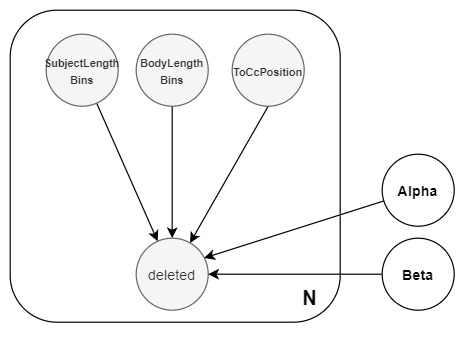

In [ ]:
# train
mat_train = df_train.values
X_train = mat_train[:,9:-16]
y_train = mat_train[:,-1].astype("int")
print("train x: {}, y: {}".format(X_train.shape, y_train.shape))

# test
mat_test = df_test.values
X_test = mat_test[:,9:-16]
y_test = mat_test[:,-1].astype("int")
print("test x: {}, y: {}".format(X_test.shape, y_test.shape))

train x: (6919, 19), y: (6919,)
test x: (2965, 19), y: (2965,)


In [ ]:
X_test[0]

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
      dtype=object)

In [ ]:
# create and fit a baseline model
logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', C=1)
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [0 1 1 ... 0 1 1]
true values: [1 0 1 ... 0 1 1]
Accuracy: 0.5858347386172007


In [ ]:
def model(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0, 5.).to_event()) # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            5.*torch.ones(X.shape[1])).to_event()) # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        logits = alpha + X.matmul(beta)
        y = pyro.sample("y", dist.Bernoulli(logits=logits), obs=obs)
        
    return y

In [ ]:
# Prepare data for Pyro
X_train = X_train.astype(np.int32)
y_train = y_train.astype(np.int32)

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()

In [ ]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 30000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 11442.5
[1000] ELBO: 7446.9
[2000] ELBO: 5478.9
[3000] ELBO: 4930.2
[4000] ELBO: 4764.9
[5000] ELBO: 4764.9
[6000] ELBO: 4762.6
[7000] ELBO: 4754.8
[8000] ELBO: 4757.4
[9000] ELBO: 4756.9
[10000] ELBO: 4756.2
[11000] ELBO: 4754.1
[12000] ELBO: 4751.0
[13000] ELBO: 4757.7
[14000] ELBO: 4756.5
[15000] ELBO: 4757.3
[16000] ELBO: 4755.7
[17000] ELBO: 4755.3
[18000] ELBO: 4755.0
[19000] ELBO: 4753.9
[20000] ELBO: 4756.6
[21000] ELBO: 4759.0
[22000] ELBO: 4750.4
[23000] ELBO: 4753.6
[24000] ELBO: 4755.4
[25000] ELBO: 4754.5
[26000] ELBO: 4757.0
[27000] ELBO: 4753.7
[28000] ELBO: 4756.7
[29000] ELBO: 4755.2


In [ ]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, y_train)

In [ ]:
alpha_hat = samples["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples["beta"].mean(axis=0).detach().numpy()

In [ ]:
# make predictions for test set
y_hat = alpha_hat + np.dot(X_test, beta_hat.T)
y_hat = np.squeeze(y_hat)
y_hat = (y_hat > 0).astype(np.int)

print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
acc_c_102 = 1.0*np.sum(y_hat == y_test) / len(y_test)
accuracies.append(acc_c_102)
print("Accuracy:", acc_c_102)

predictions: [0 1 1 ... 0 1 1]
true values: [1 0 1 ... 0 1 1]
Accuracy: 0.575716694772344


## 04.04. Classifier 103

In this model we add the topics and we train a classifier using the following features:
- BodyLength Bins (One-of-N-feature)
- SubjectLength Bins (One-of-N-feature)
- ToCcPosiiton features (One-of-N-feature)
- Topics (Numeric features)

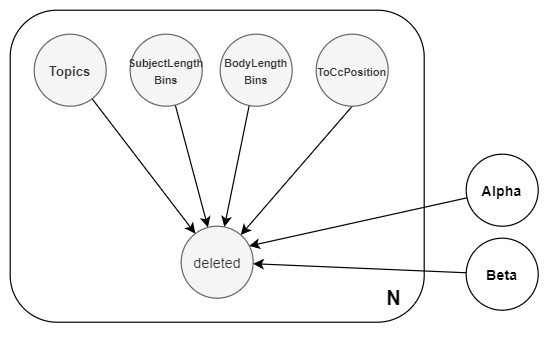

In [ ]:
# train
mat_train = df_train.values
X_train = mat_train[:,9:-1]
y_train = mat_train[:,-1].astype("int")
print("train x: {}, y: {}".format(X_train.shape, y_train.shape))

# test
mat_test = df_test.values
X_test = mat_test[:,9:-1]
y_test = mat_test[:,-1].astype("int")
print("test x: {}, y: {}".format(X_test.shape, y_test.shape))

train x: (6919, 34), y: (6919,)
test x: (2965, 34), y: (2965,)


In [ ]:
X_test[0]

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0.03177008032798767, 0.11562417447566986, 0.010028446093201637,
       0.023842154070734978, 0.10039882361888885, 0.04919179901480675,
       0.028667258098721504, 0.02402244508266449, 0.17819194495677948,
       0.012879566289484501, 0.01247168704867363, 0.009657864458858967,
       0.02725379541516304, 0.008314359001815319, 0.36768561601638794],
      dtype=object)

In [ ]:
# create and fit a baseline model
logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', C=1)
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [0 0 1 ... 0 1 1]
true values: [1 0 1 ... 0 1 1]
Accuracy: 0.5834738617200674


In [ ]:
def model(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0, 5.).to_event()) # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            5.*torch.ones(X.shape[1])).to_event()) # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        logits = alpha + X.matmul(beta)
        y = pyro.sample("y", dist.Bernoulli(logits=logits), obs=obs)
        
    return y

In [ ]:
# Prepare data for Pyro
X_train = X_train.astype(np.float64)
y_train = y_train.astype(np.int32)

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()

In [ ]:
X_train[0]

tensor([0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0218, 0.0919, 0.0069, 0.0164, 0.2664, 0.0724, 0.0197, 0.0165,
        0.0442, 0.0094, 0.0086, 0.0066, 0.0209, 0.0057, 0.3926])

In [ ]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 30000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 11172.5
[1000] ELBO: 6560.6
[2000] ELBO: 4851.5
[3000] ELBO: 4774.7
[4000] ELBO: 4768.6
[5000] ELBO: 4758.0
[6000] ELBO: 4757.7
[7000] ELBO: 4756.1
[8000] ELBO: 4749.3
[9000] ELBO: 4753.8
[10000] ELBO: 4758.9
[11000] ELBO: 4752.0
[12000] ELBO: 4756.2
[13000] ELBO: 4753.9
[14000] ELBO: 4755.5
[15000] ELBO: 4754.8
[16000] ELBO: 4752.9
[17000] ELBO: 4751.7
[18000] ELBO: 4751.5
[19000] ELBO: 4753.0
[20000] ELBO: 4751.5
[21000] ELBO: 4752.8
[22000] ELBO: 4752.3
[23000] ELBO: 4752.1
[24000] ELBO: 4751.0
[25000] ELBO: 4752.0
[26000] ELBO: 4749.9
[27000] ELBO: 4751.7
[28000] ELBO: 4752.3
[29000] ELBO: 4752.1


In [ ]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, y_train)

In [ ]:
alpha_hat = samples["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples["beta"].mean(axis=0).detach().numpy()

In [ ]:
# make predictions for test set
y_hat = alpha_hat + np.dot(X_test, beta_hat.T)
y_hat = np.squeeze(y_hat)
y_hat = (y_hat > 0).astype(np.int)

print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
acc_c_103 = 1.0*np.sum(y_hat == y_test) / len(y_test)
accuracies.append(acc_c_103)
print("Accuracy:", acc_c_103)

predictions: [0 0 1 ... 0 1 1]
true values: [1 0 1 ... 0 1 1]
Accuracy: 0.5804384485666104


# 05. Hierarchal Classification

Here we want to model personalized choices of users for which emails they consider clutter and which they consider non-clutter. So we experiment with two hierarchal models with and without email topics.

## 05.01. Prepare Dataset

We need to add a unique integer identifier for every individual to be used in the hierarchal model.

In [ ]:
final_df.head()

,sname,name,email1,email2,subject,processedBody,bowBody,subjectLength,bodyLength,notOnToOrCcLine,firstOnToLine,secondOnToLine,thirdOrLaterOnToLine,firstOnCcLine,secondOrLaterOnCcLine,bodyLength[0-100],bodyLength[101-200],bodyLength[201-400],bodyLength[401-1000],bodyLength[1001-2000],bodyLength[2001-5000],bodyLength[>5000],subjectLength[0-7],subjectLength[8-13],subjectLength[14-20],subjectLength[21-30],subjectLength[31-45],subjectLength[>45],topic01,topic02,topic03,topic04,topic05,topic06,topic07,topic08,topic09,topic10,topic11,topic12,topic13,topic14,topic15,deleted
0,beck-s,Sally Beck,sally.beck@enron.com,sally.beck@enron.com,\\spr1inf1\sapfiles\ifout\04000\20020102-DENWE...,"[payment, business, emailthi, isare, unit, tha...","[(11, 1), (120, 1), (225, 1), (260, 1), (424, ...",50,242,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.021829,0.091879,0.006890,0.016382,0.266443,0.072445,0.019697,0.016506,0.044190,0.009381,0.008569,0.006636,0.020877,0.005713,0.392563,0
1,bass-e,"Bass, Eric",eric.bass@enron.com,eric.bass@enron.com,Holiday Specials from Hawaiitropicals.com,"[today, novelty, reply, consist, price, gift, ...","[(0, 1), (32, 1), (43, 1), (48, 1), (54, 1), (...",41,1810,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0.247094,0.063344,0.002073,0.061400,0.039416,0.038206,0.111409,0.004965,0.016921,0.002685,0.016026,0.002004,0.005682,0.015165,0.373610,1
2,allen-p,"Allen, Phillip K.",k..allen@enron.com,phillip.allen@enron.com,Mortgage rates hit new lows,"[today, receipt, brokerdealer, reply, reserve,...","[(0, 1), (11, 1), (15, 1), (32, 1), (41, 1), (...",27,3055,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0.157582,0.070119,0.052106,0.078287,0.109527,0.084157,0.003841,0.026250,0.026601,0.034757,0.009434,0.009210,0.037483,0.017509,0.283137,1
3,ward-k,"Ward, Kim S.",s..ward@enron.com,kim.ward@enron.com,,[cell],"[(1972, 1)]",0,77,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0.047087,0.074944,0.014863,0.035337,0.052378,0.072908,0.042489,0.035604,0.095323,0.019089,0.018485,0.014314,0.040394,0.012323,0.424461,0
4,zipper-a,"Zipper, Andy",andy.zipper@enron.com,,GIDDINGS BBQ FLY IN DEC 15,"[noon, see, flyin, successful, like, bean, pil...","[(19, 1), (20, 1), (47, 1), (50, 1), (67, 1), ...",27,916,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0.008533,0.103858,0.002687,0.006684,0.051875,0.061260,0.037960,0.006464,0.099943,0.021313,0.044093,0.092402,0.052321,0.002228,0.408379,0


In [ ]:
snames = [sname for sname in final_df['sname'].unique()]
final_df['ind'] = final_df.apply(lambda row: snames.index(row['sname']) + 1, axis = 1)
final_df = final_df[[c for c in final_df if c not in ['deleted']] + ['deleted']]
ind_column = final_df.pop('ind')
final_df.insert(1, 'ind', ind_column)

In [ ]:
final_df.head()

,sname,ind,name,email1,email2,subject,processedBody,bowBody,subjectLength,bodyLength,notOnToOrCcLine,firstOnToLine,secondOnToLine,thirdOrLaterOnToLine,firstOnCcLine,secondOrLaterOnCcLine,bodyLength[0-100],bodyLength[101-200],bodyLength[201-400],bodyLength[401-1000],bodyLength[1001-2000],bodyLength[2001-5000],bodyLength[>5000],subjectLength[0-7],subjectLength[8-13],subjectLength[14-20],subjectLength[21-30],subjectLength[31-45],subjectLength[>45],topic01,topic02,topic03,topic04,topic05,topic06,topic07,topic08,topic09,topic10,topic11,topic12,topic13,topic14,topic15,deleted
0,beck-s,1,Sally Beck,sally.beck@enron.com,sally.beck@enron.com,\\spr1inf1\sapfiles\ifout\04000\20020102-DENWE...,"[payment, business, emailthi, isare, unit, tha...","[(11, 1), (120, 1), (225, 1), (260, 1), (424, ...",50,242,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.021829,0.091879,0.006890,0.016382,0.266443,0.072445,0.019697,0.016506,0.044190,0.009381,0.008569,0.006636,0.020877,0.005713,0.392563,0
1,bass-e,2,"Bass, Eric",eric.bass@enron.com,eric.bass@enron.com,Holiday Specials from Hawaiitropicals.com,"[today, novelty, reply, consist, price, gift, ...","[(0, 1), (32, 1), (43, 1), (48, 1), (54, 1), (...",41,1810,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0.247094,0.063344,0.002073,0.061400,0.039416,0.038206,0.111409,0.004965,0.016921,0.002685,0.016026,0.002004,0.005682,0.015165,0.373610,1
2,allen-p,3,"Allen, Phillip K.",k..allen@enron.com,phillip.allen@enron.com,Mortgage rates hit new lows,"[today, receipt, brokerdealer, reply, reserve,...","[(0, 1), (11, 1), (15, 1), (32, 1), (41, 1), (...",27,3055,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0.157582,0.070119,0.052106,0.078287,0.109527,0.084157,0.003841,0.026250,0.026601,0.034757,0.009434,0.009210,0.037483,0.017509,0.283137,1
3,ward-k,4,"Ward, Kim S.",s..ward@enron.com,kim.ward@enron.com,,[cell],"[(1972, 1)]",0,77,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0.047087,0.074944,0.014863,0.035337,0.052378,0.072908,0.042489,0.035604,0.095323,0.019089,0.018485,0.014314,0.040394,0.012323,0.424461,0
4,zipper-a,5,"Zipper, Andy",andy.zipper@enron.com,,GIDDINGS BBQ FLY IN DEC 15,"[noon, see, flyin, successful, like, bean, pil...","[(19, 1), (20, 1), (47, 1), (50, 1), (67, 1), ...",27,916,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0.008533,0.103858,0.002687,0.006684,0.051875,0.061260,0.037960,0.006464,0.099943,0.021313,0.044093,0.092402,0.052321,0.002228,0.408379,0


In [ ]:
# split train/test 
train_perc = 0.7 # percentage of training data
split_point = int(train_perc*len(final_df))

df_train = final_df.iloc[:split_point,:]
df_test = final_df.iloc[split_point+1:,:]

print("train df:", df_train.shape)
print("test df: ", df_test.shape)

train df: (6919, 45)
test df:  (2965, 45)


## 05.02. Classifier 201

A starter hierarchal model using the following features:
- BodyLength Bins (One-of-N-feature)
- SubjectLength Bins (One-of-N-feature)
- ToCcPosiiton features (One-of-N-feature)

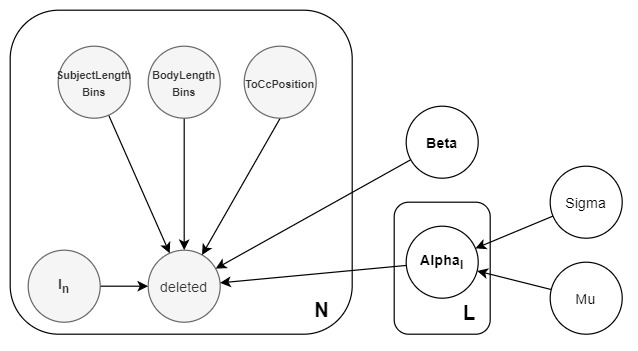

In [ ]:
# train
mat_train = df_train.values
X_train = mat_train[:,10:-16]
y_train = mat_train[:,-1].astype("int")
ind_train = mat_train[:,1].astype("int")
print("train x: {}, y: {}, ind: {}".format(X_train.shape, y_train.shape, ind_train.shape))

# test
mat_test = df_test.values
X_test = mat_test[:,10:-16]
y_test = mat_test[:,-1].astype("int")
ind_test = mat_test[:,1].astype("int")
print("test x: {}, y: {}, ind: {}".format(X_test.shape, y_test.shape, ind_test.shape))

train x: (6919, 19), y: (6919,), ind: (6919,)
test x: (2965, 19), y: (2965,), ind: (2965,)


In [ ]:
def hierarchical_model(X, ind, n_ind, obs=None):
    input_dim = X.shape[1]

    alpha_mu = pyro.sample("alpha_mu", dist.Normal(0, 10.).to_event()) # Prior for the bias mean
    alpha_sigma  = pyro.sample("alpha_sigma",  dist.HalfCauchy(10.).to_event()) # Prior for the bias standard deviation

    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim), 10.*torch.ones(input_dim)).to_event()) 
    
    with pyro.plate("ind", n_ind):
        alpha = pyro.sample("alpha", dist.Normal(alpha_mu, alpha_sigma).to_event())

    with pyro.plate("data", X.shape[0]):
        logits = alpha[ind] + X.matmul(beta)
        y = pyro.sample("y", dist.Bernoulli(logits=logits), obs=obs)
        
    return y

In [ ]:
X_train = X_train.astype(np.float64)
y_train = y_train.astype(np.int32)

In [ ]:
X_train[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1.])

In [ ]:
# Prepare data for Pyro model
n_ind = ind_train.max()
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
ind_train = torch.tensor(ind_train).long() # these are indices, therefore they need to be (long) integers

In [ ]:
X_train.shape, n_ind

(torch.Size([6919, 19]), 32)

In [ ]:
%%time

nuts_kernel = NUTS(hierarchical_model)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=100, num_chains=1)
mcmc.run(X_train, ind_train-1, n_ind, y_train)

Sample: 100%|██████████| 600/600 [04:19,  2.31it/s, step size=3.39e-02, acc. prob=0.926]

CPU times: user 4min 18s, sys: 1.58 s, total: 4min 19s
Wall time: 4min 19s


In [ ]:
samples = mcmc.get_samples()
beta_samples = samples["beta"].detach().numpy()
alpha_samples = samples["alpha"].detach().numpy()
alpha_mu_samples = samples["alpha_mu"].detach().numpy()
alpha_sigma_samples = samples["alpha_sigma"].detach().numpy()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


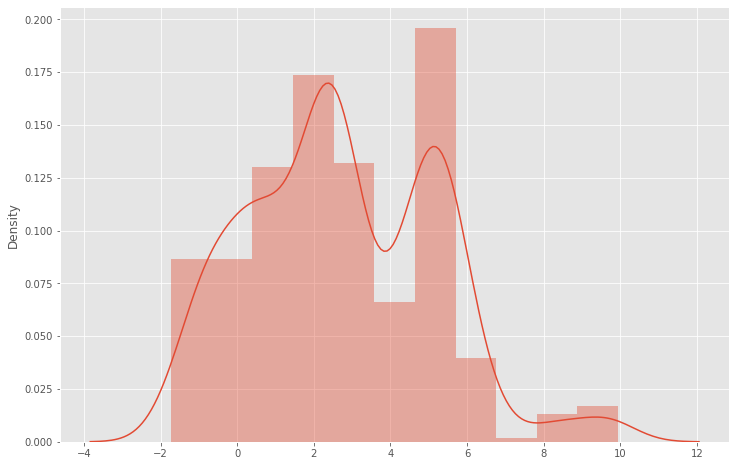

In [ ]:
sns.distplot(alpha_mu_samples)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


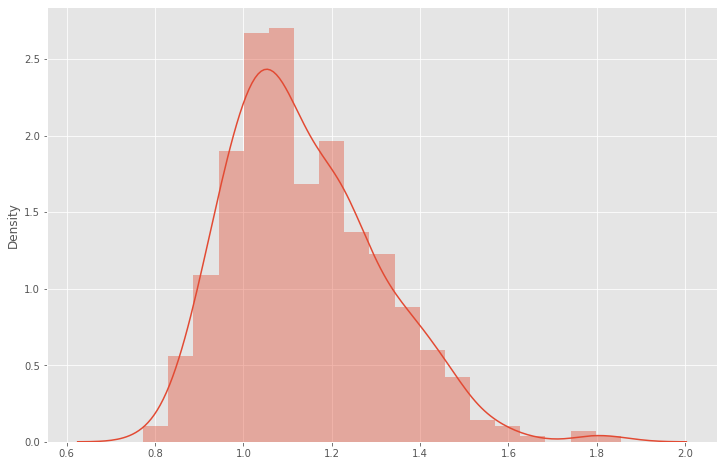

In [ ]:
sns.distplot(alpha_sigma_samples)
plt.show()

In [ ]:
# extract expected values of the parameters
alpha_hat = samples["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples["beta"].mean(axis=0).detach().numpy()

In [ ]:
# make predictions for test set
y_hat = alpha_hat[ind_test-1] + np.dot(X_test, beta_hat.T)
y_hat = np.squeeze(y_hat)
y_hat = (y_hat > 0).astype(np.int)

print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
acc_c_201 = 1.0*np.sum(y_hat == y_test) / len(y_test)
accuracies.append(acc_c_201)
print("Accuracy:", acc_c_201)

predictions: [1 1 1 ... 0 0 1]
true values: [1 0 1 ... 0 1 1]
Accuracy: 0.6428330522765598


## 05.03. Classifer 202

A hierarchal model which uses the topics:
- BodyLength Bins (One-of-N-feature)
- SubjectLength Bins (One-of-N-feature)
- ToCcPosiiton features (One-of-N-feature)
- Topics (Numeric features)

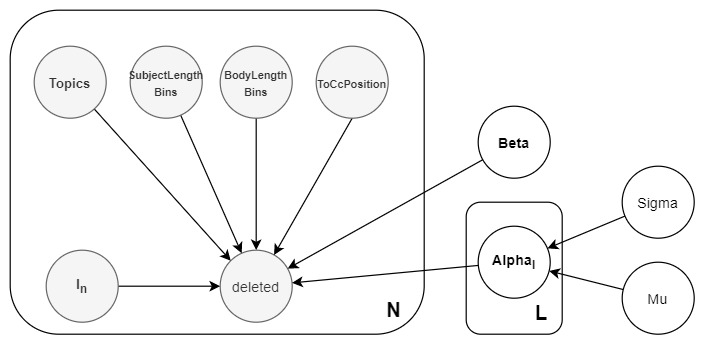

In [ ]:
# train
mat_train = df_train.values
X_train = mat_train[:,10:-1]
y_train = mat_train[:,-1].astype("int")
ind_train = mat_train[:,1].astype("int")
print("train x: {}, y: {}, ind: {}".format(X_train.shape, y_train.shape, ind_train.shape))

# test
mat_test = df_test.values
X_test = mat_test[:,10:-1]
y_test = mat_test[:,-1].astype("int")
ind_test = mat_test[:,1].astype("int")
print("test x: {}, y: {}, ind: {}".format(X_test.shape, y_test.shape, ind_test.shape))

train x: (6919, 34), y: (6919,), ind: (6919,)
test x: (2965, 34), y: (2965,), ind: (2965,)


In [ ]:
def hierarchical_model(X, ind, n_ind, obs=None):
    input_dim = X.shape[1]

    alpha_mu = pyro.sample("alpha_mu", dist.Normal(0, 10.).to_event()) # Prior for the bias mean
    alpha_sigma  = pyro.sample("alpha_sigma",  dist.HalfCauchy(10.).to_event()) # Prior for the bias standard deviation

    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim), 10.*torch.ones(input_dim)).to_event()) 
    
    with pyro.plate("ind", n_ind):
        alpha = pyro.sample("alpha", dist.Normal(alpha_mu, alpha_sigma).to_event()) 

    with pyro.plate("data", X.shape[0]):
        logits = alpha[ind] + X.matmul(beta)
        y = pyro.sample("y", dist.Bernoulli(logits=logits), obs=obs)
        
    return y

In [ ]:
X_train = X_train.astype(np.float64)
y_train = y_train.astype(np.int32)

In [ ]:
X_train[0]

array([0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.02182894,
       0.0918789 , 0.00689045, 0.01638173, 0.26644301, 0.07244524,
       0.01969702, 0.01650561, 0.04419015, 0.00938133, 0.00856918,
       0.00663583, 0.02087654, 0.00571272, 0.39256328])

In [ ]:
# Prepare data for Pyro model
n_ind = ind_train.max()
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
ind_train = torch.tensor(ind_train).long() # these are indices, therefore they need to be (long) integers

In [ ]:
X_train.shape, n_ind

(torch.Size([6919, 34]), 32)

In [ ]:
%%time

nuts_kernel = NUTS(hierarchical_model)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=100, num_chains=1)
mcmc.run(X_train, ind_train-1, n_ind, y_train)

Sample: 100%|██████████| 600/600 [18:28,  1.85s/it, step size=1.35e-02, acc. prob=0.843]

CPU times: user 18min 22s, sys: 5.17 s, total: 18min 27s
Wall time: 18min 28s


In [ ]:
samples = mcmc.get_samples()
beta_samples = samples["beta"].detach().numpy()
alpha_samples = samples["alpha"].detach().numpy()
alpha_mu_samples = samples["alpha_mu"].detach().numpy()
alpha_sigma_samples = samples["alpha_sigma"].detach().numpy()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


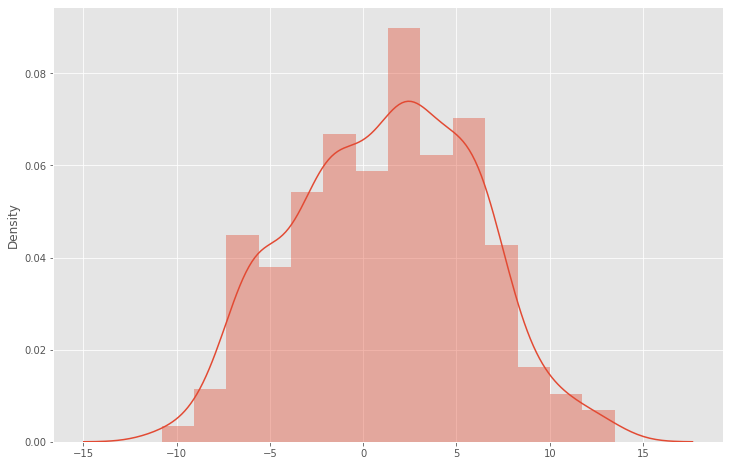

In [ ]:
sns.distplot(alpha_mu_samples)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


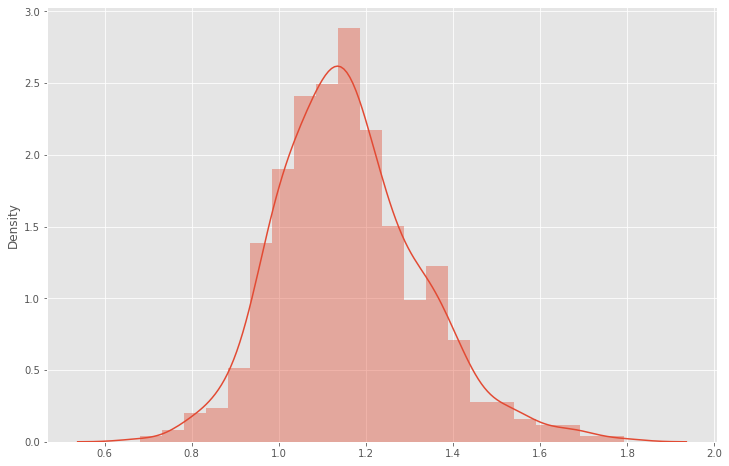

In [ ]:
sns.distplot(alpha_sigma_samples)
plt.show()

In [ ]:
# extract expected values of the parameters
alpha_hat = samples["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples["beta"].mean(axis=0).detach().numpy()

In [ ]:
# make predictions for test set
y_hat = alpha_hat[ind_test-1] + np.dot(X_test, beta_hat.T)
y_hat = np.squeeze(y_hat)
y_hat = (y_hat > 0).astype(np.int)

print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
acc_c_202 = 1.0*np.sum(y_hat == y_test) / len(y_test)
accuracies.append(acc_c_202)
print("Accuracy:", acc_c_202)

predictions: [1 1 1 ... 0 0 1]
true values: [1 0 1 ... 0 1 1]
Accuracy: 0.6536256323777403


# 06. Comparing Results

In [ ]:
# reconstruct the list again, in case of multiple runs
accuracies = []
accuracies.append(acc_c_101)
accuracies.append(acc_c_102)
accuracies.append(acc_c_103)
accuracies.append(acc_c_201)
accuracies.append(acc_c_202)

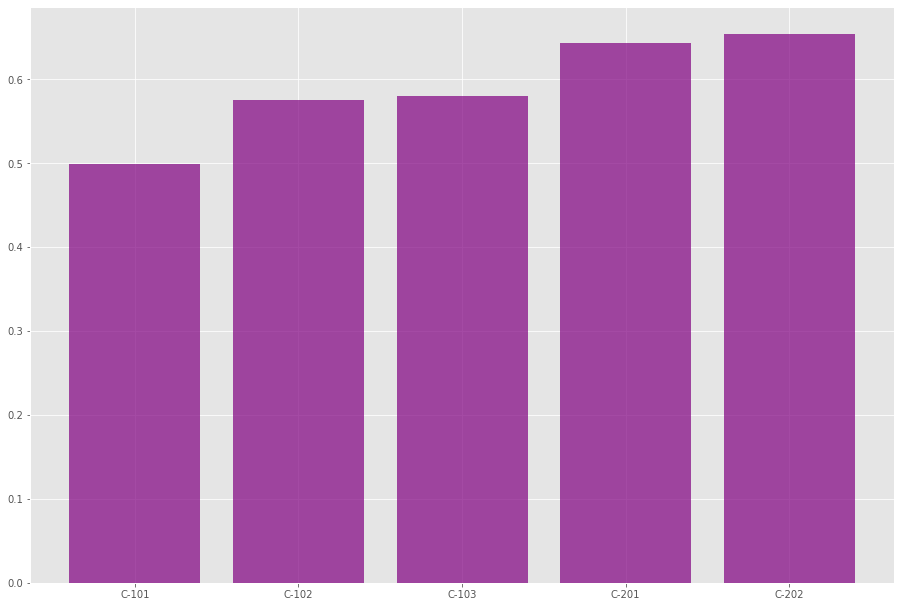

In [ ]:
# plotting the accuracy of all the models
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['C-101', 'C-102', 'C-103', 'C-201', 'C-202']
ax.bar(labels, accuracies, color='purple', alpha=0.7)
plt.show()